# Email Tracking BOT Detection - Larger Dataset

## Problem
In the Data Exploration notebook, we only looked at requests from a single campaign.  This was for 2 reasons:
- This campaign was know to have BOT activity
- The dateset was small and easy to work with

### But this limited dataset does not portray all campaigns.
- Some campaigns target certain audiences adding a bias
- Different subscription lists may only send out a campaign once every day or two
- BOT may only run during certain times of the day
- IP Addresses from a NAT and/or CIDR Range are rotated and some IPs/CIDRs may only get used every other day

When the CIDR Reputation Scores were run against the non-anonymized SQL data, it identified virtually all the CIDR ranges from suspected BOT activity.

But when the CIDR Reputation Scores were run against several days of data, only about 60% of the CIDR ranges were identified.
This is most likely due to the fact that the single campaign dataset did not see there CIDRs or the CIDRs were underrepresented.



![alt text](Diagrams/NAT.png "NAT")

### DBSCAN Performance

The DBSCAN clustering model was extremely helpful in accurately finding BOT CIDR Ranges in our dataset with a single campaign.  The runtime for DBSCAN was only a minute or 2 with about 24,000 rows.  

But because of the non-linear time complexity of the algorithm, larger datasets fail to return after more than an hour.  

Ideally, we would want to run a full week of data, but if we are able to get 2 days, it would be much better than a single campaign.

We could shop around for another algorithm, perhaps ones that utilize GPU processing, but since the SKLearn package was so good in our data exploration, we will try to find ways of running the larger dataset using the same package.


In [1]:
import numpy as np
from collections import defaultdict
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import os.path
from os import path
import pickle

### BotDataSet Class

We will use the same BotDataSet class as before, but merge in extra rows from a second csv file.

This takes us from 24,058 rows with the single campaign to 149,675 rows.

In [2]:
exec(open("BotDataSet.py").read())

In [3]:
botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8.csv')
botDataSet.loadCSV('C:/data/2020-01-17.csv', append=True)
df = botDataSet.df

In [4]:
pd.options.display.max_columns = None
display(df.head()) 
print(df.shape)
print('RequestDate Range: {}:{}'.format(df['RequestDate'].min(), df['RequestDate'].max()))
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{2091AC3A-12C7-8FBF-3AA8-8C8C5F874EE2},{9AD7D4CE-E247-DA9B-6E99-F5255E45F42F},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
1,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{C7757DCC-7F71-8FAB-6836-0B061F8668F0},{1508EC2E-DA30-4661-442A-74EAD9243FE2},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
2,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{B68FB2B6-F5FF-B7DA-22DD-589DF7AE29F7},{08E594F2-2009-3FB3-17F6-A37ABD24F6C9},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
3,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{81E9F200-AB2B-54DE-B91D-506F173DA998},{4A03B84C-1010-D5C7-3541-127FBB258929},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
4,{F4724933-4570-E4BE-9B17-3D0928E9EE76},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{048D23DD-04F1-D783-DB55-4BA2891DAA60},{49F7F9A3-19F9-6E8A-5896-BC10581E5868},{30634283-D150-237A-87FD-DA097EBBE5B9},"Amazon.com, Inc.",16509,{4ED21F0C-8573-052A-670B-E4D315133AF5},{F89AA673-49FE-433F-7447-040277C7D897},{C595CAFD-E63F-58ED-E8C8-8DB70C548720},{C6A21CB1-169B-B0F6-A812-35899D02D459},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0,1.0


(149675, 25)
RequestDate Range: 2020-01-15 20:37:00:2020-01-21 11:49:00


InboxID                  85034
Company                     27
List                        96
Campaign                  1188
RequestType                  1
SendDate                  6617
RequestDate               4371
Link                      7399
IPAddress                74974
UserAgent                 4760
AS Name                     24
AS Number                   25
CIDR Range                1009
UserID                   76989
DomainID                  6585
EmailDomain               6585
EmailRootLevelDomain        93
CountryCode                197
RegionCode                 210
PostalCode                8485
Lat                       4436
Long                      4637
OlsonName                  158
SendRequestSeconds       10549
SendRequestSeconds_ln    10549
dtype: int64

## Extend Dataframe with Session Columns

### Here, we will only use the same IPAddress/UserAgent session we did with the single campign.

In [5]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'IPUASessionID':('IPAddress', 'UserAgent')}

for t in session_columns.items():
    new_column_name, group_tuple = t
    group_column_1, group_column_2 = group_tuple
    botDataSet.loadSessionColumn(new_column_name, max_session_time_gap, group_column_1, group_column_2)

df = botDataSet.df

In [6]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.keys()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,IPUASessionID
21605,2020-01-15 20:37:00,{B716D961-C783-7E34-253B-FD592B660C4B},{B33F3237-AB65-02DD-91D7-45BA116B1EBB},Unknown,Unknown,5801810565462856523
8970,2020-01-15 20:37:00,{934C2AAB-1A5B-B7B6-4521-6AF69C9643FA},{86A7E21E-DB2E-618A-AC36-7E2AEB3A1A9F},{08344B5B-1334-9CF5-3E62-AE1C3DEA4B43},701,-5029525088015209075
40742,2020-01-15 20:37:00,{4845D598-EC85-19F1-CD1B-A224D234C609},{AA4AC190-92AC-94E1-233A-FB08EFE338FA},Unknown,Unknown,-260466438117607497
98981,2020-01-15 20:37:00,{63C17C5D-E662-5BD7-A590-BF5EA46187AD},{1D1FA5DB-1042-BD84-0B54-298E128D8CC2},Unknown,Unknown,-5115435060522805596
32616,2020-01-15 20:37:00,{31B5D5BB-DE08-C2BD-D900-41B25F2C8B17},{4AEA0AF5-C3C4-6C7D-DEF7-931284E8CFD1},Unknown,Unknown,-2543389006845859654


RequestDate       4371
InboxID          85034
IPAddress        74974
CIDR Range        1009
AS Number           25
IPUASessionID    98588
dtype: int64

## Build Aggregations

We will buid the same aggredations as before, but just for IPUA.

### Build Column Lists

In [7]:
# IPUA Sessions
IPUA_agg = {   'IPAddress':'min',
               'UserAgent':'min',
               'IPUASessionID':'size',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}


IPUA_agg_renames = { 'IPUASessionID': 'RequestCount', 
                     'InboxID': 'UniqueInboxIDs', 
                     'UserID': 'UniqueEmails', 
                     'EmailDomain': 'UniqueEmailDomains', 
                     'EmailRootLevelDomain': 'UniqueEmailRootLevelDomain', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

IPUA_unsup_columns = [ 'RequestCount',
                       'UniqueInboxIDs',
                       'UniqueEmails',
                       'UniqueEmailDomains',
                       'UniqueEmailRootLevelDomain',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']

# Clustering IP/UA Session Data

# But how do we reduce the run time?

### Dimension reduction makes the most sense since we want to keep all the rows in this dataset

#### Looking at the pair plot (covariance/corr), we see a lot of highly dependent feature, emptily in the email hierarchy

### So lets take 3 approaches for feature reduction:
- Remove rows that do not have a CIDR Range since we primarily want the CIDR Reputation Score
- Manually remove some obvious linear dependent features
- Use PCA to reduce the remaining features

RequestCount, UniqueInboxIDs, UniqueEmails, UniqueEmailDomains, UniqueEmailRootLevelDomain all show a very strong correlation, so let’s just keep one of these.  From domain knowledge, UniqueEmails is probably the best candidate.  


In [8]:
df = df[df['CIDR Range'] != 'Unknown']
df.shape

(54716, 26)

In [9]:
#IP and User Agent
df_IPUA_agg =  df.groupby(['IPUASessionID']).agg(IPUA_agg)
df_IPUA_agg.rename(columns=IPUA_agg_renames, inplace=True)

# Reduced aggs to use for DBSCAN
df_IPUA_agg_unsup = df_IPUA_agg[IPUA_unsup_columns].copy()

# Scale as before
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

df_IPUA_agg_unsup_s = getScaledDataFrame(df_IPUA_agg_unsup)
unsup_data = {'IP + UA':df_IPUA_agg_unsup_s}

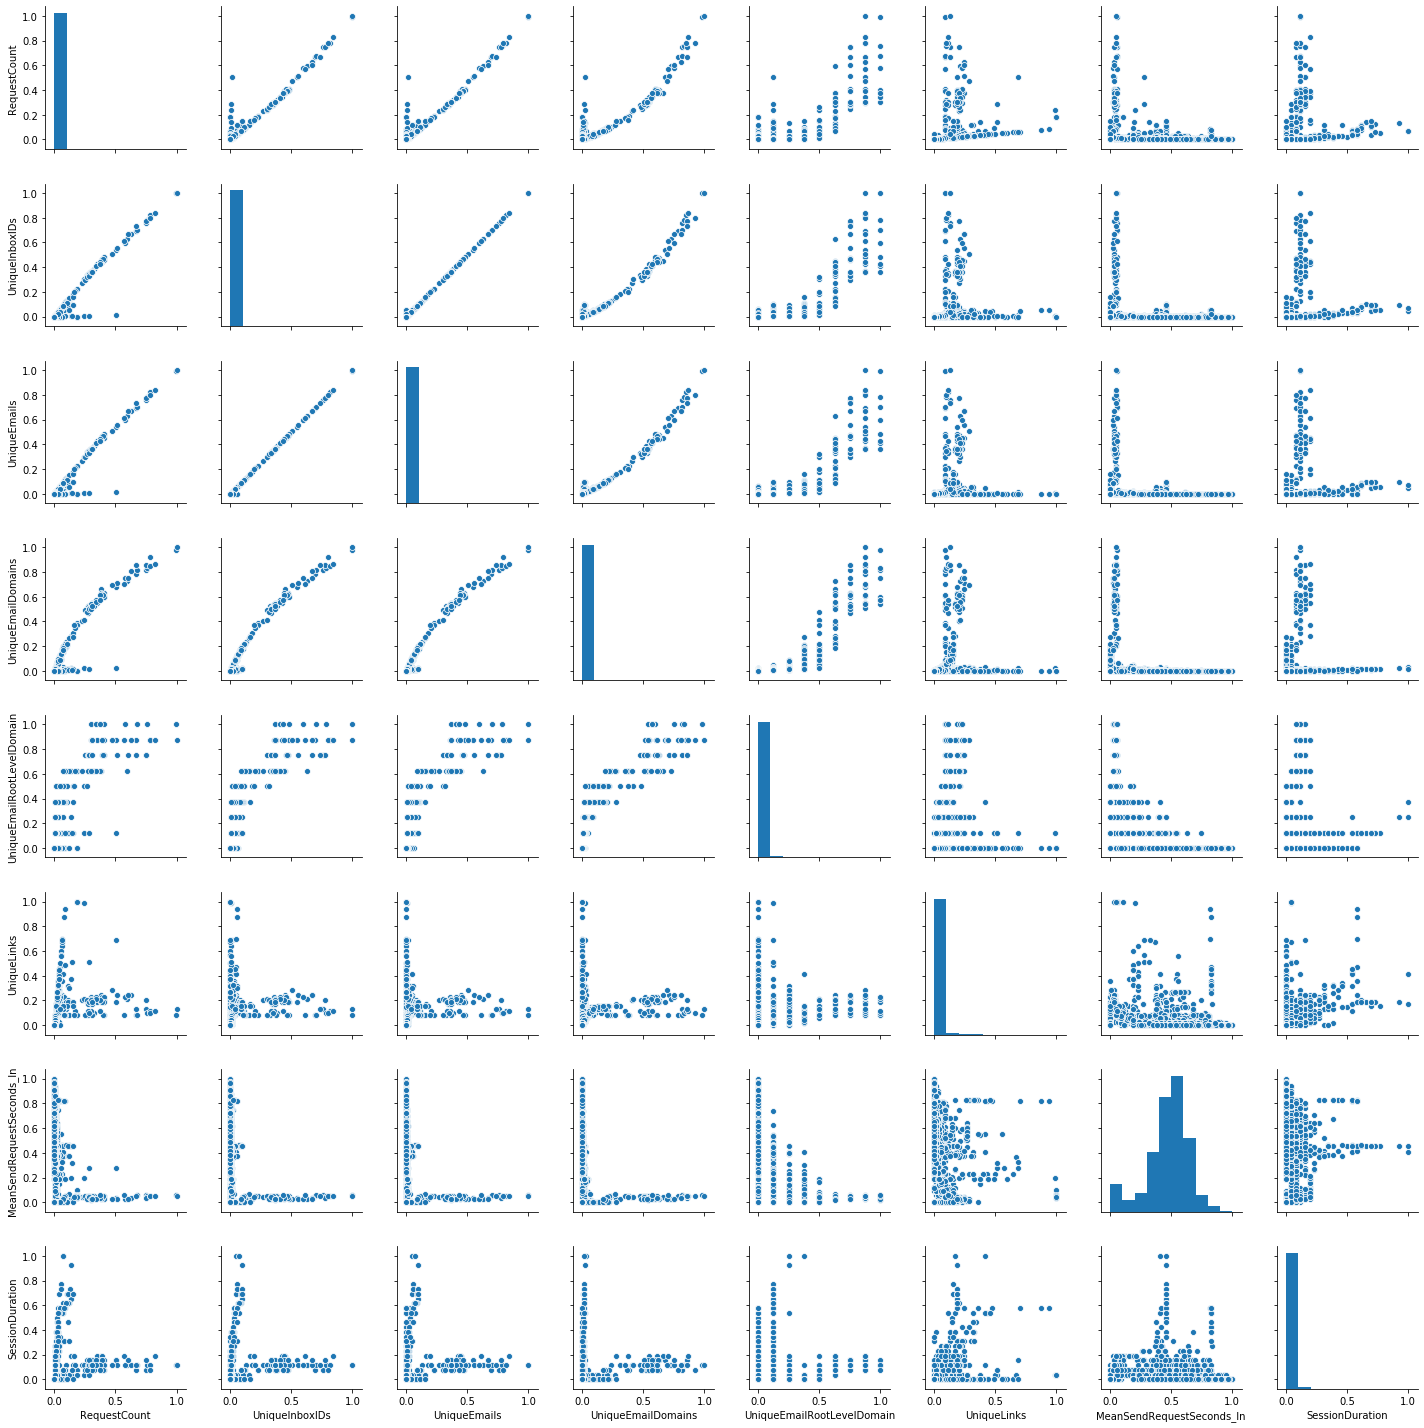

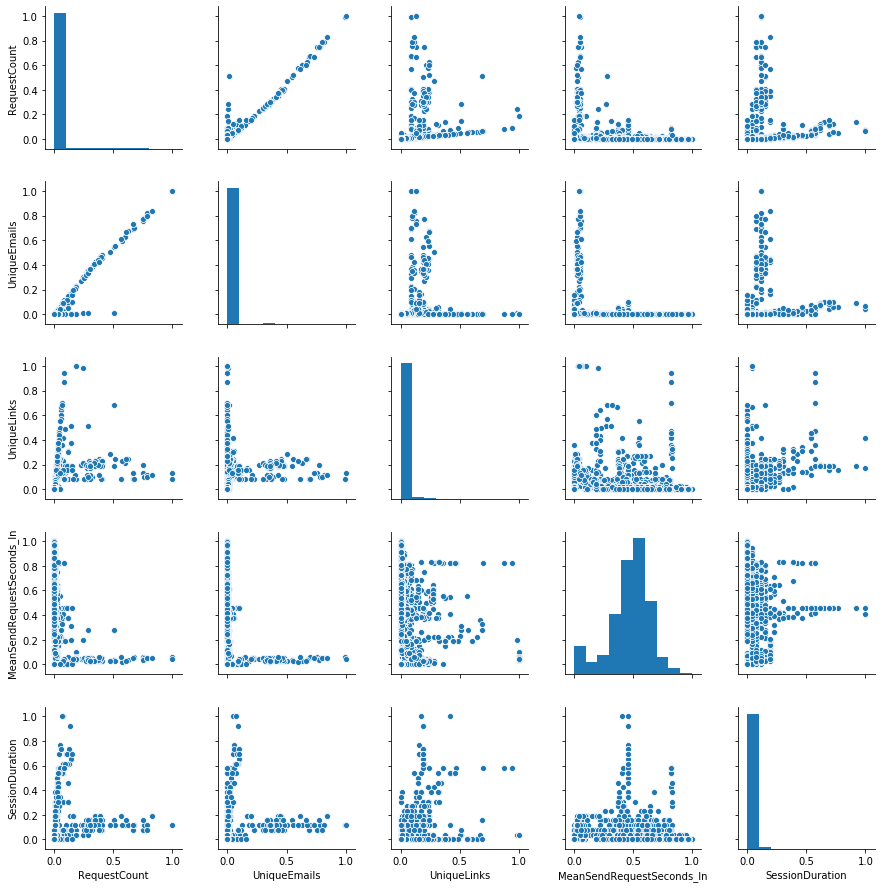

In [10]:
sns.pairplot(df_IPUA_agg_unsup_s)
plt.show()

IPUA_unsup_columns = [ 'RequestCount',
                       'UniqueEmails',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']
df_IPUA_agg_unsup_s = df_IPUA_agg_unsup_s[IPUA_unsup_columns].copy()

sns.pairplot(df_IPUA_agg_unsup_s)

# PCA

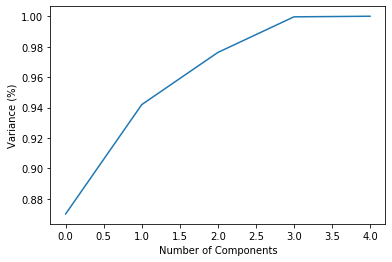

array([8.70087670e-01, 7.18458311e-02, 3.42678616e-02, 2.34101254e-02,
       3.88512155e-04])

In [11]:
pca = PCA()
pca_fit = pca.fit(df_IPUA_agg_unsup_s)
plt.figure()
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.show()
pca_fit.explained_variance_ratio_

## So out of the 4 remaining features, we can get ~88% of the variance with the first PC and about 96% with the first 2 PCs.  

In [12]:
df_IPUA_PCA = pca.transform(df_IPUA_agg_unsup_s)
df_IPUA_PCA = pd.DataFrame(df_IPUA_PCA)
df_IPUA_PCA
df_IPUA_PCA_0 = pd.DataFrame(df_IPUA_PCA.loc[:, 0].copy())
df_IPUA_PCA_0_1 = pd.DataFrame(df_IPUA_PCA.loc[:, [0,1]].copy())

# DBSCAN IP/UA Session

Let’s use the first 2 Principal Components since with the feature and row reductions, we should be able to get good DBSCAN performance

We will need to adjust the Epsilon parameter to the roughly 3 to 4 labels 


In [13]:
filename = 'C:/data/IPUA_DBSCAN.model'
build_new_model = True
if not path.exists(filename):
    build_new_model = True
    
if build_new_model:
    model = DBSCAN(eps=.2, min_samples=2, n_jobs=1)
    model.fit(df_IPUA_agg_unsup_s)
    pickle.dump(model, open(filename, 'wb'))
else:
    model = pickle.load(open(filename, 'rb'))

labels = model.labels_
print('Label min = {}\nLabel max = {}'.format(np.nanmin(labels), np.nanmax(labels)))

Label min = -1
Label max = 3


## Append the DBSCAN Lables to the 2 IP group by DataFrames

In [14]:
df_IPUA_agg['IPUA_Labels'] = labels #Origional Group By with additional agg columns
df_IPUA_agg_unsup['IPUA_Labels'] = labels #Normilized Aggregations
df_IPUA_agg_unsup_s['IPUA_Labels'] = labels #Not=Normilized Aggregations

## Build visualizations to manually inspect effectiveness of clusters

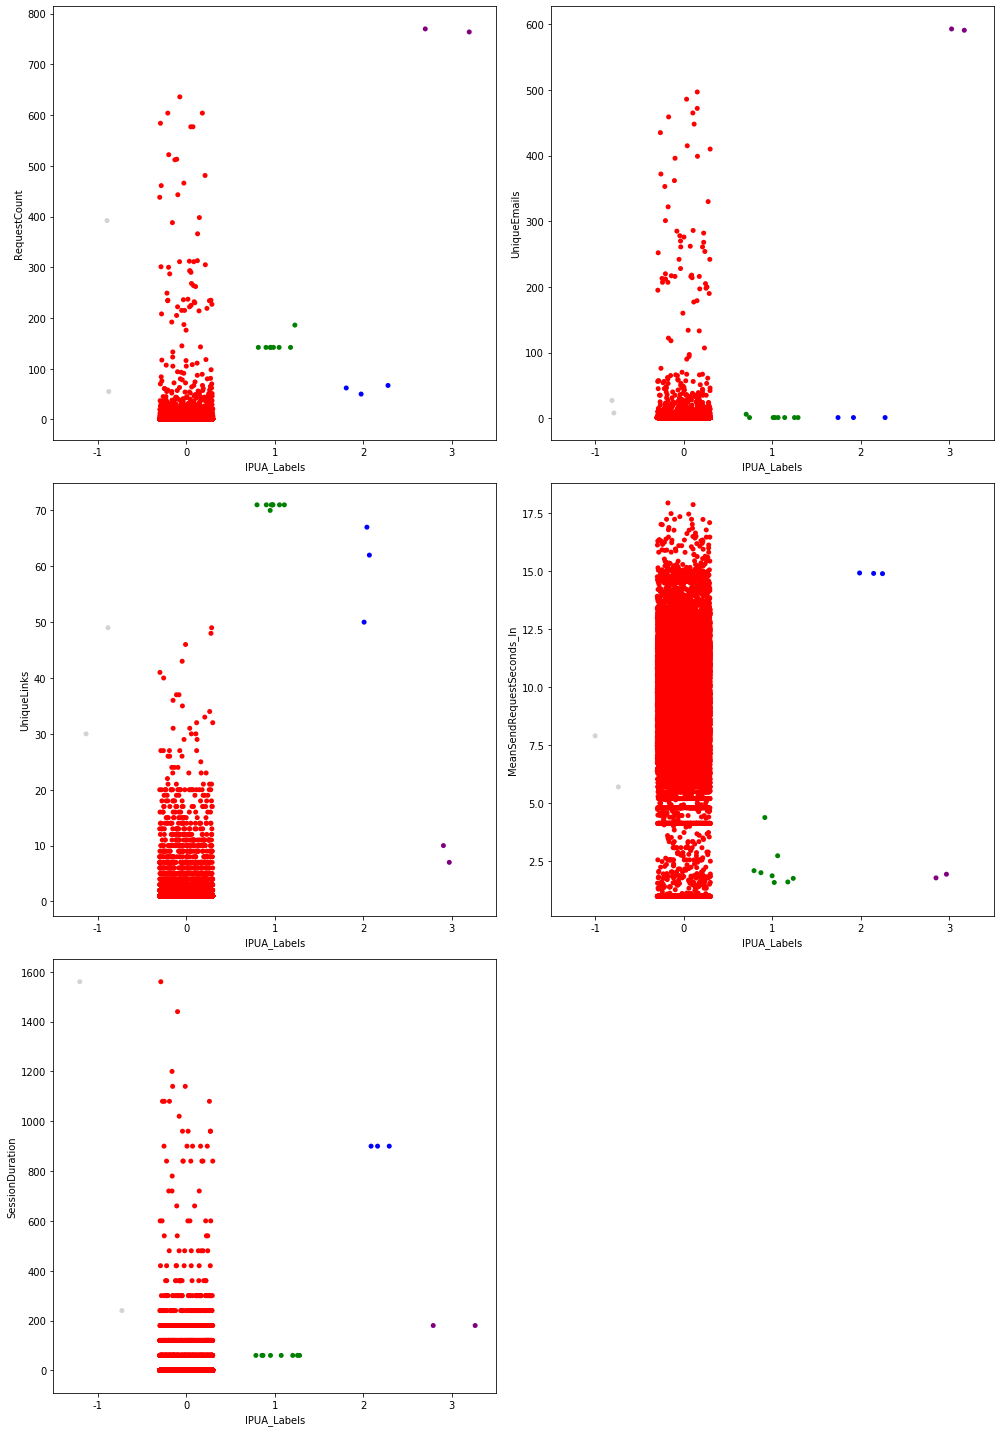

In [15]:
palette = {-1:'lightgray', 0:'r', 1:'g',2:'b', 3:'purple', 4:'cyan', 5:'black'}
i = 0
j = 0
row_count = len(IPUA_unsup_columns) // 2
if (len(IPUA_unsup_columns) % 2) != 0:
    row_count +=1
f = plt.figure(figsize=(14, 20))
gs = f.add_gridspec(row_count, 2)

for feature in IPUA_unsup_columns:
    ax = f.add_subplot(gs[i, j])
    sns.stripplot(x='IPUA_Labels', y=feature, palette=palette, jitter=.3, data=df_IPUA_agg)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

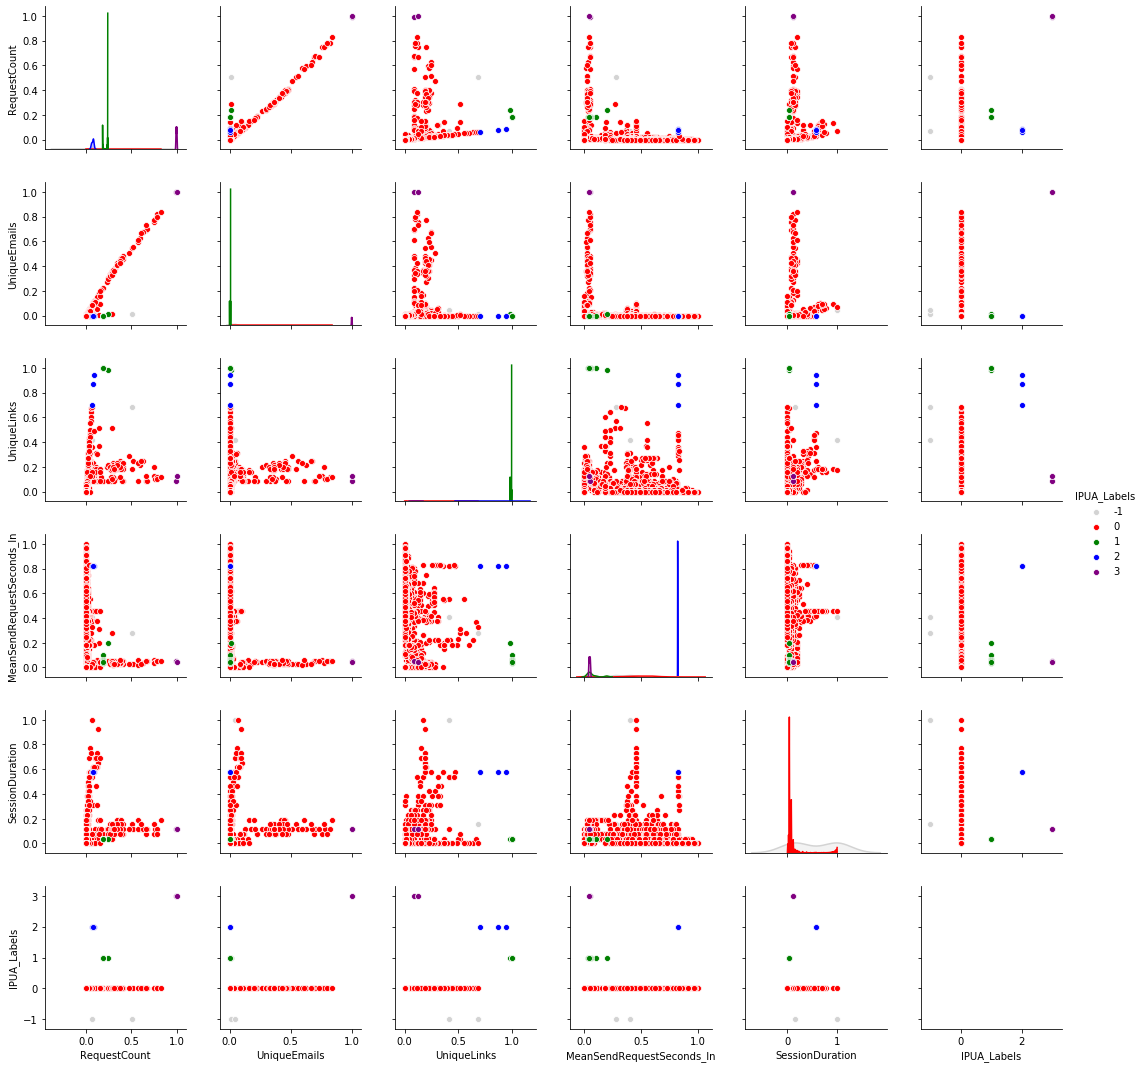

In [16]:
np.seterr(divide='ignore', invalid='ignore')
sns.pairplot(df_IPUA_agg_unsup_s, hue='IPUA_Labels', palette=palette)

# Merge the DBSCAN labels for IP/US GroupBy with original df

## Remember, so far we have been looking at the group by DataFrame

Now that we merged the DBSCAN Lables into the raw date, we will see different cardinality then our groupby dataframes.  This is because many rows from the origional DataFrame can have the same IP and User Agent

In [17]:
df = botDataSet.df

#Note:  This will be an inner join
df_IPUA_clusters = pd.merge(df, df_IPUA_agg['IPUA_Labels'], on="IPUASessionID")

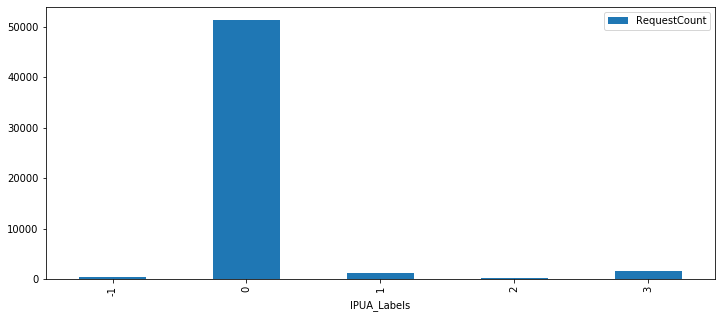

In [18]:
p= pd.DataFrame(df_IPUA_clusters.groupby(['IPUA_Labels'])['InboxID'].count())
p = p.unstack(0, )
p = p.reset_index('IPUA_Labels')
p.columns = ['IPUA_Labels', 'RequestCount']
p.plot.bar('IPUA_Labels', 'RequestCount', figsize=(12,5))

In [19]:
nunique_columns = [ 'InboxID',
                    'Company',
                    'List',
                    'Campaign',
                    'Link',
                    'IPAddress',
                    'UserAgent',
                    'AS Name',
                    'AS Number',
                    'CIDR Range',
                    'EmailDomain',
                    'EmailRootLevelDomain']
gb = df_IPUA_clusters.groupby(['IPUA_Labels'])[nunique_columns].nunique()
gb=gb.transpose()
gb

IPUA_Labels,-1,0,1,2,3
InboxID,35,18390,13,42,952
Company,3,26,3,1,1
List,3,81,3,3,1
Campaign,4,582,3,42,1
Link,78,3800,141,179,10
IPAddress,2,10219,3,3,2
UserAgent,2,1723,8,1,1
AS Name,1,23,2,1,1
AS Number,1,24,2,1,1
CIDR Range,1,1008,3,3,2


## Show distribution of these labels across the AS Names

In [20]:
def groupByPivot(group_column_top, group_column_left, count_column):
    gb = df_IPUA_clusters.groupby([group_column_top, group_column_left])[count_column].count()
    gb.fillna(0, inplace=True)
    gb = gb.unstack(0)
    gb.fillna(0, inplace=True)
    gb['All'] = gb[0] + gb[1] + gb[2] + gb[3] + gb[-1]  
    gb.sort_values('All', ascending=False, inplace=True)
    return gb

In [21]:
groupByPivot('IPUA_Labels', 'AS Name','InboxID')

IPUA_Labels,-1,0,1,2,3,All
AS Name,,,,,,
"Amazon.com, Inc.",447.0,31654.0,186.0,179.0,1534.0,34000.0
AT&T Mobility LLC,0.0,8241.0,0.0,0.0,0.0,8241.0
"MCI Communications Services, Inc. Verizon Business",0.0,2766.0,0.0,0.0,0.0,2766.0
"T-Mobile USA, Inc.",0.0,1754.0,0.0,0.0,0.0,1754.0
"CenturyLink Communications, LLC",0.0,1113.0,0.0,0.0,0.0,1113.0
Johns Hopkins University,0.0,63.0,994.0,0.0,0.0,1057.0
Scalair SAS,0.0,1034.0,0.0,0.0,0.0,1034.0
Google LLC,0.0,917.0,0.0,0.0,0.0,917.0
TELUS Communications Inc.,0.0,856.0,0.0,0.0,0.0,856.0


In [22]:
groupByPivot('IPUA_Labels', 'AS Number','InboxID')

IPUA_Labels,-1,0,1,2,3,All
AS Number,,,,,,
16509,0.0,26262.0,0.0,179.0,1534.0,27975.0
20057,0.0,8241.0,0.0,0.0,0.0,8241.0
14618,447.0,5392.0,186.0,0.0,0.0,6025.0
701,0.0,2766.0,0.0,0.0,0.0,2766.0
21928,0.0,1754.0,0.0,0.0,0.0,1754.0
209,0.0,1113.0,0.0,0.0,0.0,1113.0
5723,0.0,63.0,994.0,0.0,0.0,1057.0
206002,0.0,1034.0,0.0,0.0,0.0,1034.0
15169,0.0,917.0,0.0,0.0,0.0,917.0


In [23]:
groupByPivot('IPUA_Labels', 'CIDR Range','InboxID').head(20)

IPUA_Labels,-1,0,1,2,3,All
CIDR Range,,,,,,
{4ED21F0C-8573-052A-670B-E4D315133AF5},0.0,10249.0,0.0,67.0,764.0,11080.0
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},0.0,3328.0,0.0,50.0,770.0,4148.0
{6194D26B-CF4C-CA86-F018-CDE54FED8393},0.0,2025.0,0.0,0.0,0.0,2025.0
{F9164193-183A-7A69-1AE7-25BD6243ED72},0.0,1867.0,0.0,62.0,0.0,1929.0
{855313BB-3482-1ADA-36A8-5D073B29C265},0.0,1795.0,0.0,0.0,0.0,1795.0
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},447.0,1118.0,186.0,0.0,0.0,1751.0
{9DA7FFE3-A644-988D-A6E7-0D6305395B19},0.0,1688.0,0.0,0.0,0.0,1688.0
{D2185CAC-6E67-82FB-603B-F5B33514B577},0.0,1547.0,0.0,0.0,0.0,1547.0
{6893DEE9-A105-29E9-F9D4-98B3411CF42B},0.0,1385.0,0.0,0.0,0.0,1385.0


## Looking at the raw data in SQL, we deteremined:

- **Label 0** - Organic click activity
- **Label 1** - BOT activity from AWS Oregon
- **Label 2** - BOT activity from AWS Oregon
- **Label 3** - BOT activity from AWS Virginia

# IPAddress/UserAgent Reputation

### We have been using the IPUASessionID for this analysis

There will be many different IPUASessionID that use use the same IP/UA combination.

So lets use the session based labeling to score the IP/UA combination reputation:

#### IPUA_score = % of all IPUASessionID with labels > 0

In [24]:
df_IPUA_rep = pd.DataFrame(df_IPUA_clusters.groupby(['IPAddress', 'UserAgent', 'IPUA_Labels'])['InboxID'].count())
df_IPUA_rep = df_IPUA_rep.unstack('IPUA_Labels').fillna(0)
df_IPUA_rep.columns = df_IPUA_rep.columns.droplevel()
df_IPUA_rep['TotalCount'] = df_IPUA_rep[0] + df_IPUA_rep[1] + df_IPUA_rep[2] + df_IPUA_rep[3] 
df_IPUA_rep['BotCount'] = df_IPUA_rep[1] + df_IPUA_rep[2] + df_IPUA_rep[3] 
df_IPUA_rep['ReputationScore'] = df_IPUA_rep['BotCount'] / df_IPUA_rep['TotalCount']
df_IPUA_rep.sort_values('ReputationScore', ascending=False)

IPUA_Labels                                                                     -1  \
IPAddress                              UserAgent                                     
{FB963F16-621E-761F-34C9-5E836E0D8436} {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}  0.0   
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}  0.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {7D82D33D-8C2A-A019-867D-2795D31629E0}  0.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}  0.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}  0.0   
...                                                                            ...   
{56C5A7D1-EC1F-45ED-C541-5DD60E5F4E3B} {F87DC183-2EAD-5AED-B536-4545C440750D}  0.0   
{56D03E83-46E5-4443-D083-D6AB002CF953} {F87DC183-2EAD-5AED-B536-4545C440750D}  0.0   
{56D8F19D-EF69-EDE0-B7D3-A3007912E1E9} {F87DC183-2EAD-5AED-B536-4545C440750D}  0.0   
{56D9B73C-6847-5B5E-410A-59246471E3AB} {F87DC183-2EAD-5AED-B536-4545C440750D}  0.0   
{FFFCC786-E008-0AE3-A67F-D96EF05C1125} {AE5F6D86-CD3F-C2A0-668A-164DADCD7C22}  0.0   

IPUA_Labels                                                                      0  \
IPAddress                              UserAgent                                     
{FB963F16-621E-761F-34C9-5E836E0D8436} {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}  0.0   
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}  0.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {7D82D33D-8C2A-A019-867D-2795D31629E0}  0.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}  0.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}  0.0   
...                                                                            ...   
{56C5A7D1-EC1F-45ED-C541-5DD60E5F4E3B} {F87DC183-2EAD-5AED-B536-4545C440750D}  5.0   
{56D03E83-46E5-4443-D083-D6AB002CF953} {F87DC183-2EAD-5AED-B536-4545C440750D}  3.0   
{56D8F19D-EF69-EDE0-B7D3-A3007912E1E9} {F87DC183-2EAD-5AED-B536-4545C440750D}  1.0   
{56D9B73C-6847-5B5E-410A-59246471E3AB} {F87DC183-2EAD-5AED-B536-4545C440750D}  1.0   
{FFFCC786-E008-0AE3-A67F-D96EF05C1125} {AE5F6D86-CD3F-C2A0-668A-164DADCD7C22}  2.0   

IPUA_Labels                                                                        1  \
IPAddress                              UserAgent                                       
{FB963F16-621E-761F-34C9-5E836E0D8436} {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}  142.0   
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}  142.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {7D82D33D-8C2A-A019-867D-2795D31629E0}  142.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}  142.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}  142.0   
...                                                                              ...   
{56C5A7D1-EC1F-45ED-C541-5DD60E5F4E3B} {F87DC183-2EAD-5AED-B536-4545C440750D}    0.0   
{56D03E83-46E5-4443-D083-D6AB002CF953} {F87DC183-2EAD-5AED-B536-4545C440750D}    0.0   
{56D8F19D-EF69-EDE0-B7D3-A3007912E1E9} {F87DC183-2EAD-5AED-B536-4545C440750D}    0.0   
{56D9B73C-6847-5B5E-410A-59246471E3AB} {F87DC183-2EAD-5AED-B536-4545C440750D}    0.0   
{FFFCC786-E008-0AE3-A67F-D96EF05C1125} {AE5F6D86-CD3F-C2A0-668A-164DADCD7C22}    0.0   

IPUA_Labels                                                                      2  \
IPAddress                              UserAgent                                     
{FB963F16-621E-761F-34C9-5E836E0D8436} {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}  0.0   
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}  0.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {7D82D33D-8C2A-A019-867D-2795D31629E0}  0.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}  0.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}  0.0   
...            

### Repeat for CIDR Range

Since most BOT requests will use different IP Addresses for their HTTP Requests, we want to score the reputation of the CIDR Range.

This might be too aggressive if the CIDR Range is used by multiple accounts, i.e. NAT belongs to AWS and is used by mutliple accounts.

In [25]:
df_CIDR_rep = pd.DataFrame(df_IPUA_clusters.groupby(['CIDR Range', 'IPUA_Labels'])['InboxID'].count())
df_CIDR_rep = df_CIDR_rep.unstack('IPUA_Labels').fillna(0)
df_CIDR_rep.columns = df_CIDR_rep.columns.droplevel()
df_CIDR_rep['TotalCount'] = df_CIDR_rep[0] + df_CIDR_rep[1] + df_CIDR_rep[2] + df_CIDR_rep[3] 
df_CIDR_rep['BotCount'] = df_CIDR_rep[1] + df_CIDR_rep[2] + df_CIDR_rep[3] 
df_CIDR_rep['ReputationScore'] = df_CIDR_rep['BotCount'] / df_CIDR_rep['TotalCount']
df_CIDR_rep.sort_values('ReputationScore', ascending=False)

IPUA_Labels,-1,0,1,2,3,TotalCount,BotCount,ReputationScore
CIDR Range,,,,,,,,
{E44683CA-DB5D-2F65-CC70-AC046343B0F1},0.0,5.0,142.0,0.0,0.0,147.0,142.0,0.965986
{BC2F789B-265E-98EA-0FB5-0250C5A808BB},0.0,56.0,852.0,0.0,0.0,908.0,852.0,0.938326
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},0.0,3328.0,0.0,50.0,770.0,4148.0,820.0,0.197686
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},447.0,1118.0,186.0,0.0,0.0,1304.0,186.0,0.142638
{4ED21F0C-8573-052A-670B-E4D315133AF5},0.0,10249.0,0.0,67.0,764.0,11080.0,831.0,0.075000
...,...,...,...,...,...,...,...,...
{5AB83458-6062-C1D5-EED2-7A7B6B3EB53F},0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
{5ADED8A3-1928-D232-A534-54DE7C77285C},0.0,34.0,0.0,0.0,0.0,34.0,0.0,0.000000
{5BB52D99-EFB9-CB37-8BF1-116A8B8318EE},0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.000000


### Save lables to csv file for manual analysis with raw non-anonymized data in SQL.

In [26]:
output = df_IPUA_rep[df_IPUA_rep['ReputationScore'] > 0]
output.to_csv('C:/data/IPUA_Reputation_Scores.csv')
output

IPUA_Labels                                                                       -1  \
IPAddress                              UserAgent                                       
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}    0.0   
{500B9043-A0ED-989D-B645-5B635BAE6841} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{5B466897-6F06-D079-C749-95F303A3B31A} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{663BEEA8-FAB0-8223-D501-75488AA44C8B} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{907BAFFD-A66B-2D34-89B1-768E3FCBD951} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{E16B4100-C6C6-E5C7-4411-02AD0C4B2D88} {59E0B8D9-09F2-ADC8-9686-9015A09FB3B8}  392.0   
{E5F01BF6-053C-1AD1-B25A-B1D55AAA0983} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {053628C9-7C5B-5E76-712B-851E56C08A69}    0.0   
                                       {3F188B17-1BAC-91D1-6EC1-B82D82980166}    0.0   
                                       {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}    0.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}    0.0   
                                       {7D82D33D-8C2A-A019-867D-2795D31629E0}    0.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}    0.0   

IPUA_Labels                                                                        0  \
IPAddress                              UserAgent                                       
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}    0.0   
{500B9043-A0ED-989D-B645-5B635BAE6841} {30634283-D150-237A-87FD-DA097EBBE5B9}   12.0   
{5B466897-6F06-D079-C749-95F303A3B31A} {30634283-D150-237A-87FD-DA097EBBE5B9}    8.0   
{663BEEA8-FAB0-8223-D501-75488AA44C8B} {30634283-D150-237A-87FD-DA097EBBE5B9}  946.0   
{907BAFFD-A66B-2D34-89B1-768E3FCBD951} {30634283-D150-237A-87FD-DA097EBBE5B9}    6.0   
{E16B4100-C6C6-E5C7-4411-02AD0C4B2D88} {59E0B8D9-09F2-ADC8-9686-9015A09FB3B8}  977.0   
{E5F01BF6-053C-1AD1-B25A-B1D55AAA0983} {30634283-D150-237A-87FD-DA097EBBE5B9}  631.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {053628C9-7C5B-5E76-712B-851E56C08A69}    0.0   
                                       {3F188B17-1BAC-91D1-6EC1-B82D82980166}    0.0   
                                       {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}    0.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}    0.0   
                                       {7D82D33D-8C2A-A019-867D-2795D31629E0}    0.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}    0.0   

IPUA_Labels                                                                        1  \
IPAddress                              UserAgent                                       
{2B92A491-4370-4271-29D3-F209DCA33779} {5BA2257A-FB79-CDA7-898E-33208B2FCB08}  142.0   
{500B9043-A0ED-989D-B645-5B635BAE6841} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{5B466897-6F06-D079-C749-95F303A3B31A} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{663BEEA8-FAB0-8223-D501-75488AA44C8B} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{907BAFFD-A66B-2D34-89B1-768E3FCBD951} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{E16B4100-C6C6-E5C7-4411-02AD0C4B2D88} {59E0B8D9-09F2-ADC8-9686-9015A09FB3B8}  186.0   
{E5F01BF6-053C-1AD1-B25A-B1D55AAA0983} {30634283-D150-237A-87FD-DA097EBBE5B9}    0.0   
{FB963F16-621E-761F-34C9-5E836E0D8436} {053628C9-7C5B-5E76-712B-851E56C08A69}  142.0   
                                       {3F188B17-1BAC-91D1-6EC1-B82D82980166}  142.0   
                                       {49F0EDFD-8DB5-2945-BFCC-D67767310A5A}  142.0   
                                       {6C6158BE-DC7D-5A03-39EE-FE8094FA8D59}  142.0   
                                       {7D82D33D-8C2A-A019-867D-2795D31629E0}  142.0   
                                       {EC03DB67-1F0D-B74E-14FF-E0234AF2123A}  142.0   

IPUA_Labels                          

In [27]:
output = df_CIDR_rep[df_CIDR_rep['ReputationScore'] > 0]
output.to_csv('C:/data/CIDR_Reputation_Scores.csv')
output

IPUA_Labels,-1,0,1,2,3,TotalCount,BotCount,ReputationScore
CIDR Range,,,,,,,,
{4ED21F0C-8573-052A-670B-E4D315133AF5},0.0,10249.0,0.0,67.0,764.0,11080.0,831.0,0.075000
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},447.0,1118.0,186.0,0.0,0.0,1304.0,186.0,0.142638
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},0.0,3328.0,0.0,50.0,770.0,4148.0,820.0,0.197686
{BC2F789B-265E-98EA-0FB5-0250C5A808BB},0.0,56.0,852.0,0.0,0.0,908.0,852.0,0.938326
{E44683CA-DB5D-2F65-CC70-AC046343B0F1},0.0,5.0,142.0,0.0,0.0,147.0,142.0,0.965986
{F9164193-183A-7A69-1AE7-25BD6243ED72},0.0,1867.0,0.0,62.0,0.0,1929.0,62.0,0.032141
